# Hypothesis Testing 

## Hypothesis - Conservative party candidates get more votes in constituencies with higher median incomes

### Data sources

We shall be using two data sources

1. `ge2015-results.csv` (provided). Note, in practice it would be quicker to filter/drop columns using Data Wrangler,¿but we'll do thépandas work ourselves

1. `Work Parliamentary Constituency Table 9.7b   Annual pay - Gross 2015 CV.xls` downloaded from ONS. XLS file so will need turning into a CSV first and 'non-data components' . Pandas can load XLS - but we would have to trim the file anyway so might as well make it a CSV.

Pandas has already been installed `pip install pandas` into a suitable `venv` so let.s start with the first file.

 For executing in a notebook in a venv we will also need the ipykernel package, `python -m pip install ipykernel -U --dorce-reinstall`. Recently the ipykernel installation was removed from the default venv (in Visual Code) to make creating a venv faster.

In [251]:
import pandas as pd

df = pd.read_csv('ge2015-results.csv')

print(df)

columns = df.columns.values.tolist()
print(columns)

         ons_id ons_region_id constituency_name      county_name  \
0     W07000049     W92000004          Aberavon   West Glamorgan   
1     W07000049     W92000004          Aberavon   West Glamorgan   
2     W07000049     W92000004          Aberavon   West Glamorgan   
3     W07000049     W92000004          Aberavon   West Glamorgan   
4     W07000049     W92000004          Aberavon   West Glamorgan   
...         ...           ...               ...              ...   
3966  E14001062     E12000003        York Outer  North Yorkshire   
3967  E14001062     E12000003        York Outer  North Yorkshire   
3968  E14001062     E12000003        York Outer  North Yorkshire   
3969  E14001062     E12000003        York Outer  North Yorkshire   
3970  E14001062     E12000003        York Outer  North Yorkshire   

                   region_name country_name constituency_type  \
0                        Wales        Wales            County   
1                        Wales        Wales          

The current columns are
```
ons_id,ons_region_id,constituency_name,county_name,region_name,country_name,constituency_type,party_name,party_abbreviation,firstname,surname,gender,sitting_mp,former_mp,votes,share,change

```
of these we will keep only `ons_id,constituency_name,country_name,party_abbreviation,votes`

The `ons_id` is a useful unique identifier, `constituency_name` is more human-readable, `country-name` because the conservative party does not exist in N.I. so we might wish to exclude those constituencies later, `party_abbreviation` as a shorter and easier proxy for party_name and `votes`. 


In [252]:
drop_columns = [c for c in columns if c not in ['ons_id','constituency_name','country_name','party_abbreviation','votes']] 
print(drop_columns)
df.drop(columns=drop_columns, inplace=True)
print(df)

['ons_region_id', 'county_name', 'region_name', 'constituency_type', 'party_name', 'firstname', 'surname', 'gender', 'sitting_mp', 'former_mp', 'share', 'change']
         ons_id constituency_name country_name party_abbreviation  votes
0     W07000049          Aberavon        Wales                Lab  15416
1     W07000049          Aberavon        Wales               UKIP   4971
2     W07000049          Aberavon        Wales                Con   3742
3     W07000049          Aberavon        Wales                 PC   3663
4     W07000049          Aberavon        Wales                 LD   1397
...         ...               ...          ...                ...    ...
3966  E14001062        York Outer      England                Con  26477
3967  E14001062        York Outer      England                Lab  13348
3968  E14001062        York Outer      England                 LD   6269
3969  E14001062        York Outer      England               UKIP   5251
3970  E14001062        York Outer 

and we'll want to filer down to just 'Con' for party and ['England',Wales','Scotland'] for country_name

In [253]:
df = df[df['party_abbreviation']=="Con"]
df = df[df['country_name']!='Northern Ireland']
print(df)


         ons_id          constituency_name country_name party_abbreviation  \
2     W07000049                   Aberavon        Wales                Con   
9     W07000058                  Aberconwy        Wales                Con   
17    S14000001             Aberdeen North     Scotland                Con   
23    S14000002             Aberdeen South     Scotland                Con   
30    S14000003         Airdrie and Shotts     Scotland                Con   
...         ...                        ...          ...                ...   
3942  E14001059  Wythenshawe and Sale East      England                Con   
3948  E14001060                     Yeovil      England                Con   
3955  W07000041                   Ynys Mon        Wales                Con   
3960  E14001061               York Central      England                Con   
3966  E14001062                 York Outer      England                Con   

      votes  
2      3742  
9     12513  
17     5304  
23    1

And we should have a look at the SOCS.


In [254]:
df.describe()


,votes
count,631.000000
mean,17893.112520
std,9068.549728
min,1215.000000
25%,9568.000000
50%,18684.000000
75%,25510.000000
max,36607.000000


array([[<Axes: title={'center': 'votes'}>]], dtype=object)

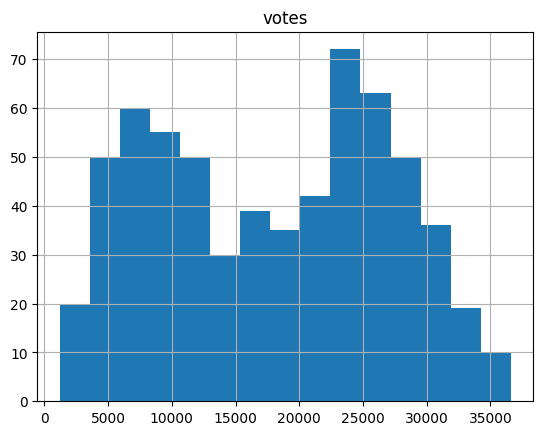

In [255]:
df.hist(column=['votes'],bins=15)

The distribution is bi-modal which is probably not too surprising given two main parties. 


So much for data-source 1. On to 2.

The columns of interest were cut out and saved as CSV to give `MedianIncomes.csv`. The column headings were lost in the process so provide some names

In [256]:
mi = pd.read_csv('MedianIncomes.csv', names=['constituency', 'id', 'number_of_jobs','median_pay(k)'])
mi.drop(columns=['number_of_jobs'], inplace=True)
print(mi)

                          constituency         id median_pay(k)
0                   Berwick-upon-Tweed  E14000554          16.0
1                      Bishop Auckland  E14000569          22.0
2                              Blaydon  E14000574          13.0
3                         Blyth Valley  E14000575          11.0
4                       City of Durham  E14000641           7.1
..                                 ...        ...           ...
637            Ross, Skye and Lochaber  S14000055          12.0
638       Rutherglen and Hamilton West  S14000056          11.0
639                           Stirling  S14000057           7.3
640  West Aberdeenshire and Kincardine  S14000058          10.0
641                West Dunbartonshire  S14000059          11.0

[642 rows x 3 columns]


Now we can try joining them on the id fields and drop fields common to both and where all rows are identical anyway ('Con')

In [257]:
merged = pd.merge(df,mi,left_on='ons_id',right_on='id')
merged.drop(columns=['constituency','id','party_abbreviation'], inplace=True)
print(merged)

        ons_id          constituency_name country_name  votes median_pay(k)
0    W07000049                   Aberavon        Wales   3742          11.0
1    W07000058                  Aberconwy        Wales  12513          13.0
2    S14000001             Aberdeen North     Scotland   5304           7.4
3    S14000002             Aberdeen South     Scotland  11087          20.0
4    S14000003         Airdrie and Shotts     Scotland   3389           7.0
..         ...                        ...          ...    ...           ...
626  E14001059  Wythenshawe and Sale East      England  11124          19.0
627  E14001060                     Yeovil      England  24178           5.8
628  W07000041                   Ynys Mon        Wales   7393          11.0
629  E14001061               York Central      England  13496           6.1
630  E14001062                 York Outer      England  26477          17.0

[631 rows x 5 columns]


Let's see what we have. We'll need `matplotlib` so `pip install matplotlib`. Also note that the 'median_pay` has ended up as an object not a number so will need casting

<class 'pandas.core.frame.DataFrame'>
Index: 616 entries, 0 to 630
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ons_id             616 non-null    object 
 1   constituency_name  616 non-null    object 
 2   country_name       616 non-null    object 
 3   votes              616 non-null    int64  
 4   median_pay(k)      616 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 28.9+ KB
None
        ons_id          constituency_name country_name  votes  median_pay(k)
0    W07000049                   Aberavon        Wales   3742           11.0
1    W07000058                  Aberconwy        Wales  12513           13.0
2    S14000001             Aberdeen North     Scotland   5304            7.4
3    S14000002             Aberdeen South     Scotland  11087           20.0
4    S14000003         Airdrie and Shotts     Scotland   3389            7.0
..         ...                     

<Axes: xlabel='median_pay(k)', ylabel='votes'>

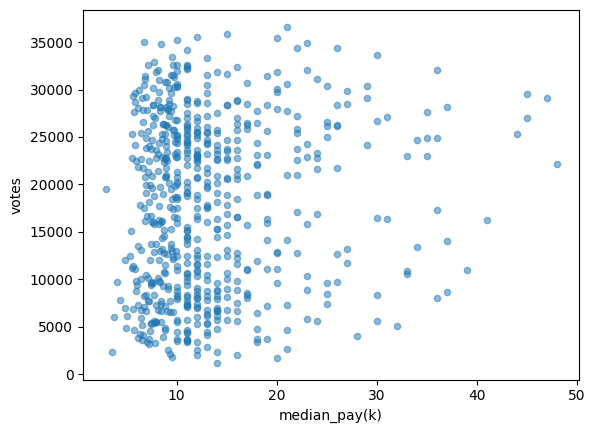

In [258]:
merged['median_pay(k)']=pd.to_numeric(merged['median_pay(k)'], errors='coerce')
merged.dropna(inplace=True)

print(merged.info())
print(merged)

merged.plot.scatter(x='median_pay(k)', y='votes', color='#1f77b4', alpha=.5)



It seems fairly clear that there is no simple correlation between these values, but just for completeness we'll calculate an r-squared anyway. 

> A little caution here ... while there is clearly no worthwhile line of best-fit on the data as a whole, we also notice that the top six constituencies by median income all had over 15000 votes, significantly above average. Similarly - if less obviously - the lowest median income constituencies were below-average for votes. It would be recommended to compare the top and bottom quartiles for _differences_ before reaching dogmatic conclusions about 'no relationship'

In [260]:
from scipy.stats import pearsonr

pearsonr(merged['votes'], merged['median_pay(k)'])


PearsonRResult(statistic=0.1056359058202748, pvalue=0.008694620408298678)

and since the pvalue is <0.05 - quite a bit less - we can tentatively assume that there is a statistically significant correlation between votes and income

In [261]:
import statsmodels.api as sm

#define response variable
y = merged['votes']

#define predictor variables
x = merged['median_pay(k)']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  votes   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.929
Date:                Wed, 31 May 2023   Prob (F-statistic):            0.00869
Time:                        12:13:42   Log-Likelihood:                -6481.1
No. Observations:                 616   AIC:                         1.297e+04
Df Residuals:                     614   BIC:                         1.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.612e+04    758.443     21.251

and the R-squared is practically zero so we may not reject the null-hypothesis that there is no _linear_ relationship between votes and pay. However, the correlation noted above means that more investigation would be needed of other types of relationship.